# Project E-Commerce: Product Range Analysis

### Overview

We will analyse an ecommerce website Gift Store to evaluate the product catalog. Our goal is to identify the best-selling products and determine the focus areas for future marketing efforts. Additionally, we'll ensure that the online product listings align with the offline inventory, and all items on the website are in stock and available for customers.

### Project Objective:

<b>The objective of this project is to boost the shop’s revenue by identifying the most popular products and product bundles, as well as the least popular products.</b>

### Analysis Scope

1) Preprocessing: We will assess the dataset, investigate each column and determine what needs fixing and cleaning.

2) Categorisation: We will categorise our product description into smaller categories. We will need to use a lemmetization function in order to assess keywords and then determine which categories are our best sellers.

3) Exploration: We'll explore the monthly sales revenue, new and returning customers as well as trying to determine the lifetime value.

4) Statistical tests: After the exploration we will use statistical tests in order to test our hypothesis.

5) Conclusion and Recommendation: We'll write our client some business recommendations to improve their revenue.

In [1]:
!pip install sidetable 

In [2]:
#Read General libraries
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
import plotly.express as px
import sidetable

# Read libraries for visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager
import plotly.express as px
import seaborn as sns

#Libraries for categorisation
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter

# View all columns in large datasets
pd.set_option("display.max_columns",None)

# Set the styling for the charts
sns.set(style='whitegrid')
facecolor = '#eaeaea'
font_color = '#525252'
csfont = {'fontname': 'Liberation Serif'}
hfont = {'fontname': 'LiberationSans-Regular'}

In [3]:
# Read Data
df=pd.read_csv("//datasets//ecommerce_dataset_us.csv",sep='\t', dtype={'invoiceno': str, 'stockcode': str})
df.columns=df.columns.str.lower()
print(df.shape)
print(df.info())

(541909, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoiceno    541909 non-null  object 
 1   stockcode    541909 non-null  object 
 2   description  540455 non-null  object 
 3   quantity     541909 non-null  int64  
 4   invoicedate  541909 non-null  object 
 5   unitprice    541909 non-null  float64
 6   customerid   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB
None


### Data Overview
We have missing data in the description column and also in the customer id column. We will need to investigate further the missing customers.

## Data Overview and Preprocessing
- Cheking the overview data.
- Checking the data for missing values, duplicates and outliers.
- Check if data types are right.

- df.shape
- df.info()

Investigate all columns.

### Describe all columns

In [4]:
df.describe(include='all')

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000
unique,25900,4070,4223,NaN,23260,NaN,NaN
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/29/2019 14:41,NaN,NaN
freq,1114,2313,2369,NaN,1114,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000


### Format all date columns

In [5]:
# There was a problem with the data, see row 312087. Some have the month first and others have the day first.
try: 
    df['invoicedate']=pd.to_datetime(df['invoicedate'],format='%d/%m/%Y %H:%M',errors='raise')
except:
    df['invoicedate']=pd.to_datetime(df['invoicedate'],format='%m/%d/%Y %H:%M',errors='raise')

### Check Duplicate entries

In [6]:
df.duplicated().sum()

5268

In [7]:
df[df.duplicated(keep='first')].sort_values(by='customerid').groupby(['customerid','invoiceno'])['invoicedate'].count()

customerid  invoiceno
12359.0     571034       3
12370.0     538826       1
12391.0     577228       7
12431.0     539419       1
12471.0     538174       1
                        ..
18283.0     560025       2
            573093       2
            575668       3
            578262       5
            579673       2
Name: invoicedate, Length: 1903, dtype: int64

In [8]:
df.drop_duplicates(inplace=True)

### Missing Values

The missing values as we observe below are in customer id and description. The description column is less than 1 percent of the data, so we can drop these values. But, the customer id needs be to checked first. 

It looks like a large bumber of the customer id that are missing have negative unit prices, this suggests that they could be refunds. Therefore, we won't need to keep these in because we're only interested in sales that have happended on the website and we will then make an analysis of the top sellers and eventually decide which the most popular items are.

In [9]:
df.stb.missing(style=True)

,missing,total,percent
customerid,"135,037","536,641",25.16%
description,"1,454","536,641",0.27%
invoiceno,0,"536,641",0.00%
stockcode,0,"536,641",0.00%
quantity,0,"536,641",0.00%
invoicedate,0,"536,641",0.00%
unitprice,0,"536,641",0.00%


### Investigate missing in all columns

In [10]:
for column in df.columns:
    if df[column].isna().sum()!=0:
        print("=======================================================")
        print(f"{column} ==> Missing Values : {df[column].isnull().sum()}, dtypes : {df[column].dtypes}")

description ==> Missing Values : 1454, dtypes : object
customerid ==> Missing Values : 135037, dtypes : float64


In [11]:
print(df['customerid'].count())
print(df['customerid'].nunique())
print(df['invoiceno'].count())
print(df['invoiceno'].nunique())

401604
4372
536641
25900


After investigation we have 4372 actual customers in our database after a unique count and there were 25900 unique orders from these customers.

In [12]:
missing_punters=df[df['customerid'].isna()]

In [13]:
df[df['customerid'].isna()]['description'].value_counts()

DOTCOM POSTAGE                        693
JUMBO BAG RED RETROSPOT               497
JUMBO STORAGE BAG SUKI                414
JUMBO SHOPPER VINTAGE RED PAISLEY     388
JUMBO BAG WOODLAND ANIMALS            372
                                     ... 
DIAMANTE BOW BROOCH BLACK COLOUR        1
wet boxes                               1
TURQUOISE HEART OF GLASS BRACELET       1
damages/display                         1
WATERING CAN SINGLE HOOK PISTACHIO      1
Name: description, Length: 3554, dtype: int64

In [14]:
df['customerid']=df['customerid'].fillna(np.nan)
df['customerid']=df['customerid'].astype('O')

So, for our research it appears that customerid won't make an impact so we don't need to drop any of the thosing missing values and our missing description can be restored. I wanted to see simply a count of the products when there is a missing customer id, it does appear that they are actual orders. However, I can also see postage, damaged goods and various others. Next I am going to check the invoice number to see if it can shed any light on why the customer id is missing, possibly they are credit notes or errors.

### Investigate Invoice, Unit Price and Quantity

In [15]:
products_per_order=df.groupby('invoiceno').agg({'quantity':'sum',
                                                'description':'nunique',
                                                'unitprice':'sum'
                                               }).reset_index().rename(columns={'description':'products per invoice',
                                                                                'quantity':'total stock ordered',
                                                                               'unitprice':'total value of order'})
products_per_order.describe()

,total stock ordered,products per invoice,total value of order
count,25900.000000,25900.000000,25900.000000
mean,199.324402,20.447336,95.987374
std,1107.976358,42.499072,494.590834
min,-80995.000000,0.000000,-11062.060000
25%,6.000000,2.000000,7.392500
50%,100.000000,10.000000,31.100000
75%,240.000000,23.000000,75.082500
max,80995.000000,1108.000000,38970.000000


In [16]:
df['quantity'].describe()

count    536641.000000
mean          9.620029
std         219.130156
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: quantity, dtype: float64

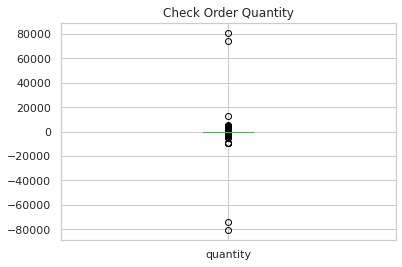

In [17]:
df.quantity.plot(kind='box',title='Check Order Quantity')
plt.show()

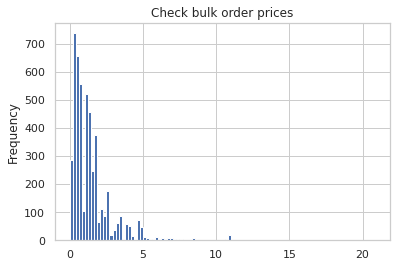

In [18]:
bulk_orders=df[df['quantity']>100]
bulk_orders['unitprice'].plot(kind='hist',bins=100, title='Check bulk order prices')
plt.show()

In [19]:
returns=df[df['quantity']<0]
error_description = returns[~returns['invoiceno'].str.contains('C5')]['description'].unique().tolist()
error_description

[nan,
 '?',
 'check',
 'damages',
 'faulty',
 'Dotcom sales',
 'reverse 21/5/10 adjustment',
 'mouldy, thrown away.',
 'counted',
 'Given away',
 'Dotcom',
 'label mix up',
 'samples/damages',
 'thrown away',
 'incorrectly made-thrown away.',
 'showroom',
 'MIA',
 'Dotcom set',
 'wrongly sold as sets',
 'Amazon sold sets',
 'dotcom sold sets',
 'wrongly sold sets',
 '? sold as sets?',
 '?sold as sets?',
 'Thrown away.',
 'damages/display',
 'damaged stock',
 'broken',
 'throw away',
 'wrong barcode (22467)',
 'wrong barcode',
 'barcode problem',
 '?lost',
 "thrown away-can't sell.",
 "thrown away-can't sell",
 'damages?',
 're dotcom quick fix.',
 "Dotcom sold in 6's",
 'sold in set?',
 'cracked',
 'sold as 22467',
 'Damaged',
 'mystery! Only ever imported 1800',
 'MERCHANT CHANDLER CREDIT ERROR, STO',
 'POSSIBLE DAMAGES OR LOST?',
 'damaged',
 'DAMAGED',
 'Display',
 'Missing',
 'wrong code?',
 'wrong code',
 'adjust',
 'crushed',
 'damages/showroom etc',
 'samples',
 'damages/credits

After an investigation of the invoice number, we can see that there are on everage 199 items (in quantity) and about 20.44 unique products (description) by invoice. On top of that the average order value is 95 USD and the majority of our orders are under 75 USD as well as the quantity rarely being over 240 and thew number of actual products (description) is usually no more than 23. Possibly, we can add unit price categories to our data frame in order to categories products into groups based on their values.

When we look at the quantity column, we have a high amount of negative values and constitute to returns, damages or errors. Therefore, so that we can focus on our sales revenue, we wil remove the quantity values that are below 0 in our database. After that we will categorise the order quantity column to split up invoices and categorise those with over 10 in quantity as bulk orders.


### Investigate Stock Code

In [20]:
df['stockcode'].describe()

count     536641
unique      4070
top       85123A
freq        2301
Name: stockcode, dtype: object

The "stockcode" column contains identifiers for products. In the dataset, there are 536,641 entries. Among these, there are 4,070 unique stock codes, indicating different products. The most frequent stock code is "85123A," occurring 2,301 times, suggesting it's a commonly occurring product.

In [21]:
df[df['stockcode']=='85123A'].groupby('stockcode').agg({'description':'nunique',
                                                        'quantity':'sum',
                                                        'customerid':'nunique'})

,description,quantity,customerid
stockcode,,,
85123A,4,38811,858


Our most frequant product ordered were T-Light Holders by the brand "Hanging Heart". There are 4 different products, 38,811 in quantity ordered and 858 unique customers.

In [22]:
df.groupby('stockcode').agg({'description':'nunique',
                             'quantity':'sum',
                             'unitprice':'sum',
                             'customerid':'nunique'}).reset_index().sort_values(by='unitprice',ascending=False).head(10)

,stockcode,description,quantity,unitprice,customerid
4037,AMAZONFEE,1,-30,249042.680,0
4060,M,1,2924,214440.910,276
4059,DOT,1,1707,206252.060,1
4062,POST,1,6353,46388.470,379
1348,22423,3,12954,30222.160,887
2733,47566,1,18010,9945.270,708
1631,22720,1,7279,8479.080,640
4041,CRUK,1,-16,7933.430,1
3496,85066,1,1743,7799.860,291
4039,BANK CHARGES,1,-13,7505.641,10


As we can see there are stockcode's callsed POST, AMAZONFEE, M, CRUK and DOT, these are not exactly products and may harm our analysis of the product. ! will now view a sample of each one, to try understanding more. It appears, that M is a manual invoice entry, so it can remain in the database, Amazon Fee is a cost to the company and not a product and CRUK appears to be commissions paid to Cancer Research UK and DOT and POST are shipping costs. Therefore, we will remove the amazon fee, shipping costs and CRUK commissions from our database.

In [23]:
df[df['stockcode']=='M'].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
2239,536569,M,Manual,1,2018-11-29 15:35:00,1.25,16274.0
2250,536569,M,Manual,1,2018-11-29 15:35:00,18.95,16274.0
5684,536865,M,Manual,1,2018-12-01 11:28:00,2.55,NaN
6798,536981,M,Manual,2,2018-12-01 14:26:00,0.85,14723.0
7976,537077,M,Manual,12,2018-12-03 11:59:00,0.42,17062.0


In [24]:
df[df['stockcode']=='AMAZONFEE'].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
14514,C537600,AMAZONFEE,AMAZON FEE,-1,2018-12-05 12:41:00,1.00,NaN
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2018-12-05 15:04:00,13541.33,NaN
15017,537632,AMAZONFEE,AMAZON FEE,1,2018-12-05 15:08:00,13541.33,NaN
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2018-12-05 15:34:00,13474.79,NaN
16313,C537647,AMAZONFEE,AMAZON FEE,-1,2018-12-05 15:41:00,5519.25,NaN


In [25]:
df[df['stockcode']=='DOT'].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
1814,536544,DOT,DOTCOM POSTAGE,1,2018-11-29 14:32:00,569.77,NaN
3041,536592,DOT,DOTCOM POSTAGE,1,2018-11-29 17:06:00,607.49,NaN
5450,536862,DOT,DOTCOM POSTAGE,1,2018-12-01 11:13:00,254.43,NaN
5545,536864,DOT,DOTCOM POSTAGE,1,2018-12-01 11:27:00,121.06,NaN
5685,536865,DOT,DOTCOM POSTAGE,1,2018-12-01 11:28:00,498.47,NaN


In [26]:
df[df['stockcode']=='POST'].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
45,536370,POST,POSTAGE,3,2018-11-29 08:45:00,18.0,12583.0
386,536403,POST,POSTAGE,1,2018-11-29 11:27:00,15.0,12791.0
1123,536527,POST,POSTAGE,1,2018-11-29 13:04:00,18.0,12662.0
5073,536840,POST,POSTAGE,1,2018-11-30 18:27:00,18.0,12738.0
5258,536852,POST,POSTAGE,1,2018-12-01 09:51:00,18.0,12686.0


In [27]:
df[df['stockcode']=='CRUK'].head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid
317508,C564763,CRUK,CRUK Commission,-1,2019-08-28 10:49:00,1.60,14096.0
324023,C565382,CRUK,CRUK Commission,-1,2019-08-31 15:45:00,13.01,14096.0
333779,C566216,CRUK,CRUK Commission,-1,2019-09-07 15:17:00,15.96,14096.0
338848,C566565,CRUK,CRUK Commission,-1,2019-09-11 12:32:00,52.24,14096.0
351003,C567655,CRUK,CRUK Commission,-1,2019-09-19 14:40:00,608.66,14096.0


### Investigate Invoice date

In [28]:
df['invoicedate'].describe(datetime_is_numeric=True)

count                           536641
mean     2019-07-02 08:57:06.087421696
min                2018-11-29 08:26:00
25%                2019-03-26 10:52:00
50%                2019-07-17 14:04:00
75%                2019-10-16 17:05:00
max                2019-12-07 12:50:00
Name: invoicedate, dtype: object

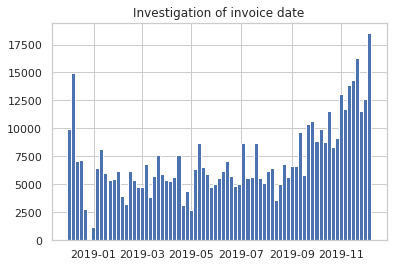

In [29]:
plt.hist(df['invoicedate'],bins='auto')
plt.title('Investigation of invoice date')
plt.show()

The highest frequancy of orders came during the end of 2019 and the beginning of 2019, with a lower frequancy through the rest of the year. Moreover, it appears that we have year-to-date (YTD) data starting from the end of Novermber 2018 and ending on December 7th 2019. There appears to be a gap in the distribution at the start of the period, which needs to be investigated. 

In this dataset, the range of invoicedates spans from November 29, 2018, to December 7, 2019. The median (50th percentile) invoicedate falls on July 17, 2019, indicating that half of the invoices were issued before this date and half after.

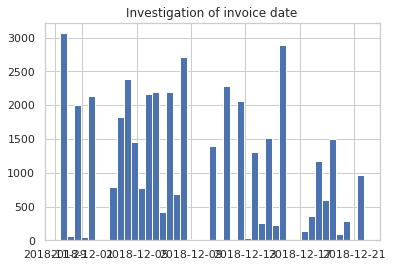

In [30]:
first_orders=df[(df['invoicedate']<'2019-01-01')]
plt.hist(first_orders['invoicedate'],bins='auto')
plt.title('Investigation of invoice date')
plt.show()

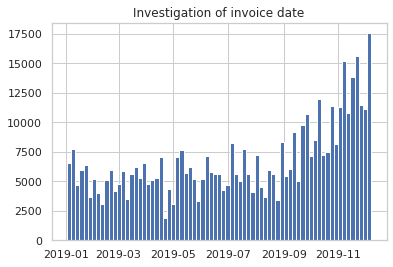

In [31]:
orders_2019=df[(df['invoicedate']>'2018-12-31')]
plt.hist(orders_2019['invoicedate'],bins='auto')
plt.title('Investigation of invoice date')
plt.show()

There are gapsin the data before 2018, I believe in order to make a more sufficient analysis it will be worthwhile to drop the values before 1st January 2019 and perform an analysis of 2019 orders only.

### Additional date columns 
Adding the name of the date, the month of the order and the year of the order for a time series analysis.
We will also add a first order order date, which we will link to the dataframe once we have cleaned it after our initial investigation.

In [32]:
df['invoiceday'] = df['invoicedate'].dt.day_name()
df['invoicemonth'] = df['invoicedate'].astype('datetime64[M]')
df['invoiceyear'] = df['invoicedate'].dt.year
df['invoicequarter'] = pd.PeriodIndex(df.invoicedate, freq='Q')
df['daytime']=df['invoicedate'].dt.hour // 8

first_customer_date=df.groupby('customerid')['invoicedate'].first().reset_index()
first_customer_date.columns=['customerid','first_order_date']

### Investigate missing descriptions
We will make an attempt to use bfill in order to fill in the missing descriptions.

In [33]:
df[df['description'].isna()]

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,invoiceday,invoicemonth,invoiceyear,invoicequarter,daytime
622,536414,22139,NaN,56,2018-11-29 11:52:00,0.0,NaN,Thursday,2018-11-01,2018,2018Q4,1
1970,536545,21134,NaN,1,2018-11-29 14:32:00,0.0,NaN,Thursday,2018-11-01,2018,2018Q4,1
1971,536546,22145,NaN,1,2018-11-29 14:33:00,0.0,NaN,Thursday,2018-11-01,2018,2018Q4,1
1972,536547,37509,NaN,1,2018-11-29 14:33:00,0.0,NaN,Thursday,2018-11-01,2018,2018Q4,1
1987,536549,85226A,NaN,1,2018-11-29 14:34:00,0.0,NaN,Thursday,2018-11-01,2018,2018Q4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,2019-12-05 18:26:00,0.0,NaN,Thursday,2019-12-01,2019,2019Q4,2
535326,581203,23406,NaN,15,2019-12-05 18:31:00,0.0,NaN,Thursday,2019-12-01,2019,2019Q4,2
535332,581209,21620,NaN,6,2019-12-05 18:35:00,0.0,NaN,Thursday,2019-12-01,2019,2019Q4,2
536981,581234,72817,NaN,27,2019-12-06 10:33:00,0.0,NaN,Friday,2019-12-01,2019,2019Q4,1


In [34]:
df.sort_values(by='stockcode',inplace=True)
df.fillna(method='bfill',inplace=True)

In [35]:
for column in df.columns:
    if df[column].isna().sum()!=0:
        print("=======================================================")
        print(f"{column} ==> Missing Values : {df[column].isnull().sum()}, dtypes : {df[column].dtypes}")

customerid ==> Missing Values : 97, dtypes : float64


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 17604 to 40383
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   invoiceno       536641 non-null  object        
 1   stockcode       536641 non-null  object        
 2   description     536641 non-null  object        
 3   quantity        536641 non-null  int64         
 4   invoicedate     536641 non-null  datetime64[ns]
 5   unitprice       536641 non-null  float64       
 6   customerid      536544 non-null  float64       
 7   invoiceday      536641 non-null  object        
 8   invoicemonth    536641 non-null  datetime64[ns]
 9   invoiceyear     536641 non-null  int64         
 10  invoicequarter  536641 non-null  period[Q-DEC] 
 11  daytime         536641 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(4), period[Q-DEC](1)
memory usage: 53.2+ MB


### Enrich Data with Categorisation
1) Add total value

2) Add category for unit price - We will go up in 20s based on the above invoice.

3) Add category for orders over 10 units

In [37]:
# Add total revenue column
df['total_value']=df['unitprice']*df['quantity']

In [38]:
# add category for unit price - We will go up in 20s based on the above invoice.
def price_ranges(unitprice):
    if unitprice < 0:
        return 'credit note/bills'
    elif unitprice < 20:
        return 'orders below 20'
    elif unitprice < 40:
        return 'orders 20 - 40'
    elif unitprice < 60:
        return 'orders 40 - 60'
    elif unitprice < 80:
        return 'orders 60 - 80'
    elif unitprice < 100:
        return 'orders 80 - 100'
    else: return 'orders 100+'
    
df['price_range']=df['unitprice'].apply(price_ranges)

In [39]:
def bulk_orders(quantity):
    if quantity >= 10:
        return 'bulk orders'
    elif quantity == 0:
        return 'no order'
    elif quantity < 0:
        return 'returns'
    else: return 'small orders'

df['order_type']=df['quantity'].apply(bulk_orders)

In [40]:
df.stb.freq(['price_range'])

,price_range,count,percent,cumulative_count,cumulative_percent
0,orders below 20,532464,99.221640,532464,99.221640
1,orders 20 - 40,2554,0.475923,535018,99.697563
2,orders 100+,1037,0.193239,536055,99.890802
3,orders 40 - 60,432,0.080501,536487,99.971303
4,orders 80 - 100,83,0.015467,536570,99.986770
5,orders 60 - 80,69,0.012858,536639,99.999627
6,credit note/bills,2,0.000373,536641,100.000000


In [41]:
df.stb.freq(['order_type'])

,order_type,count,percent,cumulative_count,cumulative_percent
0,small orders,371511,69.228963,371511,69.228963
1,bulk orders,154543,28.798210,526054,98.027173
2,returns,10587,1.972827,536641,100.000000


The majority of our orders are below 20 dollars and the majority of our orders were smaller orders with less than 10 items. Moreover around 1.9% of the data has been classed as a return due to the quantity being negative.

To summarise the preparation efforts, we will now clean the datframe in order to perform the best possible exploratory and statisical analysis of our online gift shop.

### Final cleaning & Preprocessing summary

Firstly, we discovered that the majority of missing values are in customerid and those that are missing won't impact our analysis. However, in the stockcode column we have names "amazon fee", shipping costs and manual entries, amazon fee and credit notes. We will remove the manual entries as it can be difficult to know what they are. In addition, we have gaps in our date column before January 2019, so we will focus our efforts on 2019 orders and drop orders from 2018.

Morevoer, we will add our categories for later analysis and then merge the first customer date on our main dataframe.

In [42]:
# Make them all title case and clean
df['description']=df['description'].str.title()
df['description']=df['description'].str.strip()

In [43]:
new_data=pd.merge(df, first_customer_date, left_on='customerid',right_on='customerid', how='left')
new_data['first_order_month']=new_data['first_order_date'].astype('datetime64[M]')

In [44]:
new_data['first_order_quarter']=pd.PeriodIndex(new_data.first_order_month, freq='Q')

In [45]:
new_data

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,invoiceday,invoicemonth,invoiceyear,invoicequarter,daytime,total_value,price_range,order_type,first_order_date,first_order_month,first_order_quarter
0,537770,10002,Inflatable Political Globe,12,2018-12-06 12:24:00,0.85,15529.0,Thursday,2018-12-01,2018,2018Q4,1,10.20,orders below 20,bulk orders,2018-12-06 12:24:00,2018-12-01,2018Q4
1,538071,10002,Inflatable Political Globe,2,2018-12-07 14:09:00,1.66,14713.0,Friday,2018-12-01,2018,2018Q4,1,3.32,orders below 20,small orders,2018-12-07 18:58:00,2018-12-01,2018Q4
2,539322,10002,Inflatable Political Globe,5,2018-12-14 19:22:00,0.85,14713.0,Friday,2018-12-01,2018,2018Q4,2,4.25,orders below 20,small orders,2018-12-07 18:58:00,2018-12-01,2018Q4
3,537047,10002,Inflatable Political Globe,1,2018-12-03 11:02:00,0.85,13069.0,Monday,2018-12-01,2018,2018Q4,1,0.85,orders below 20,small orders,2018-12-03 11:02:00,2018-12-01,2018Q4
4,537638,10002,Inflatable Political Globe,5,2018-12-05 15:28:00,1.66,14258.0,Wednesday,2018-12-01,2018,2018Q4,1,8.30,orders below 20,small orders,2019-01-04 12:18:00,2019-01-01,2019Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536636,558614,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,2019-06-28 15:56:00,41.67,NaN,Friday,2019-06-01,2019,2019Q2,1,41.67,orders 40 - 60,small orders,NaT,NaT,NaT
536637,552232,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,2019-05-04 15:54:00,41.67,NaN,Saturday,2019-05-01,2019,2019Q2,1,41.67,orders 40 - 60,small orders,NaT,NaT,NaT
536638,539958,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,2018-12-21 13:26:00,42.55,NaN,Friday,2018-12-01,2018,2018Q4,1,42.55,orders 40 - 60,small orders,NaT,NaT,NaT
536639,558066,gift_0001_50,Dotcomgiftshop Gift Voucher £50.00,1,2019-06-22 15:45:00,41.67,NaN,Saturday,2019-06-01,2019,2019Q2,1,41.67,orders 40 - 60,small orders,NaT,NaT,NaT


In [46]:
new_data=new_data[(new_data['invoicedate']>'2018-12-31')
                   & (new_data['first_order_date']>'2018-12-31')&
                   (~new_data['stockcode'].isin(['BANK CHARGES','DOT','POST','POSTAGE','AMAZONFEE','M','CRUK','B','D'])) &
                   (new_data['price_range']!='credit note/bills') 
                   & (new_data['quantity']>0)].copy()

In [47]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286601 entries, 5 to 535287
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   invoiceno            286601 non-null  object        
 1   stockcode            286601 non-null  object        
 2   description          286601 non-null  object        
 3   quantity             286601 non-null  int64         
 4   invoicedate          286601 non-null  datetime64[ns]
 5   unitprice            286601 non-null  float64       
 6   customerid           286601 non-null  float64       
 7   invoiceday           286601 non-null  object        
 8   invoicemonth         286601 non-null  datetime64[ns]
 9   invoiceyear          286601 non-null  int64         
 10  invoicequarter       286601 non-null  period[Q-DEC] 
 11  daytime              286601 non-null  int64         
 12  total_value          286601 non-null  float64       
 13  price_range   

## Create Product Categories
Before we begin our exploration, we will create categories for the products in our database based on keywords in their descriptions.

In [48]:
new_data.stb.freq(['description']).head(10)

,description,count,percent,cumulative_count,cumulative_percent
0,White Hanging Heart T-Light Holder,1158,0.404046,1158,0.404046
1,Jumbo Bag Red Retrospot,1086,0.378924,2244,0.782970
2,Regency Cakestand 3 Tier,1048,0.365665,3292,1.148635
3,Party Bunting,989,0.345079,4281,1.493714
4,Lunch Bag Red Retrospot,830,0.289601,5111,1.783315
5,Set Of 3 Cake Tins Pantry Design,820,0.286112,5931,2.069428
6,Assorted Colour Bird Ornament,809,0.282274,6740,2.351701
7,Natural Slate Heart Chalkboard,738,0.257501,7478,2.609202
8,Pack Of 72 Retrospot Cake Cases,721,0.251569,8199,2.860772
9,Paper Chain Kit 50'S Christmas,705,0.245987,8904,3.106758


As we noticed before, the most popular product was the T-Light Holder by Hanging Heart. This table tells use the frequancy of each product and how often they appear on invoices. There is no dominant product here as our top 10 products had less then a percent.

### Check if there are any keywords that appear more often?
Firstly, we will check the types of keywords in our database and write a lemmitization function, printing the top 50 keywords.

In [49]:
wordnet_lemma = WordNetLemmatizer()  # Define WordNetLemmatizer object
ps = PorterStemmer()

lemmas_list_all = []

for purpose in df.description.unique():
    words = nltk.word_tokenize(purpose)
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words]
    lemmas=[l.lower() for l in lemmas]
    for i in lemmas:
        if i==',':
            continue
        else:    
            lemmas_list_all.append(i)

In [50]:
total_words=Counter(lemmas_list_all)
top_50=total_words.most_common(50)
print(f"Top Keywords: {top_50}")

Top Keywords: [('set', 327), ('pink', 303), ('of', 240), ('heart', 237), ('vintage', 220), ('blue', 217), ('red', 198), ('bag', 171), ('christmas', 157), ('glass', 157), ('box', 140), ('white', 132), ('design', 129), ('holder', 117), ('small', 115), ('flower', 115), ('metal', 111), ('large', 106), ('hanging', 104), ('green', 103), ('decoration', 101), ('necklace', 100), ('black', 99), ('rose', 99), ('wall', 97), ('retrospot', 96), ('3', 95), ('candle', 93), ('t-light', 89), ('card', 88), ('silver', 86), ('paper', 85), ('cake', 83), ('and', 83), ('with', 83), ('in', 79), ('art', 78), ('garden', 72), ('polkadot', 71), ('mug', 71), ('earrings', 69), ('wrap', 68), ('bracelet', 68), ('ivory', 67), ('4', 66), ('cover', 65), ('pack', 64), ('6', 64), ('sign', 64), ('mini', 61)]


Using these keywords, we will try to make a function and group our keywords together to make categories.

### Use lemmatize to create a function to identify keywords from the description

In [51]:
def lemmatization_function(line):
    words = nltk.word_tokenize(line)
    lemmas = [wordnet_lemma.lemmatize(w,pos='n') for w in words]
    lemmas = [l.lower() for l in lemmas]
    return lemmas

In [52]:
new_data['lemmat_categ']=new_data['description'].apply(lemmatization_function)

In [53]:
love_theme = ['heart','love','cupid','pink']
vintage_theme = ['vintage','retro','retrospot','antique','traditional','edwardian']
home_garden = ['home','garden']
greeting_cards = ['birthday','card','cards']
kitchen_items = ['cutlery','plate','cake','mug','tea','bottle',
                 'apron','kitchen','cakestand','cup','teacup',
                 'saucer','teaspoons','recipe','towels','teatowels',
                 'herb','popcorn','cookie','cutter','platers','fork',
                 'knife','bowl','plates','teapot','cakes',
                 'popcorn holder','bread bin']
decorative_products = ['decoration','flower','style','doormat','drawerknob',
                       'rack','cushion','shelf','polka','picture','frame',
                       'bunting','curtain','sign','charm','calm','holder'
                       'ornament','chest','drawer','miror','assorted',
                       'board','globe']
lighting_products = ['candle','t-light','lantern','lamp',
                     'tealight','candles','light','lights',
                     'candles','hanging']
jewellery_products = ['bracelet','necklace','clock','trinket']             
christmas_products = ['christmas','fairy', 'tale','santa']
bag_products=['bag','bags','jumbo','shopper','lunch','lunch box']
assorted_products = ['pack','set','pack of','sets',
                     'packs','bags','sleigh']
internal = ['post','postage','packaging','commission','manual',
            'carriage','Cash']
childrens = ['childrens','playhouse','doll','feltcraft',
             'plasters']
British_products = ['jubilee', 'union', 'jack']
glove_products = ['hand','glove','gloves','warmer','hand warmer']

In [54]:
#function with only one possible category
def lemmatization_func(line):
    words = nltk.word_tokenize(line)
    lemmas = [wordnet_lemma.lemmatize(w, pos = 'n') for w in words]
    lemmas=[l.lower() for l in lemmas]
    
    if any(words in lemmas for words in love_theme):
        return 'Valentines Gifts'
    elif any(words in lemmas for words in vintage_theme):
        return 'Vintage Gifts'
    elif any(words in lemmas for words in home_garden):
        return 'Home and Garden'
    elif any(words in lemmas for words in decorative_products):
        return 'Decorative homewares'
    elif  any(words in lemmas for words in kitchen_items):
        return 'Kitchen and Cookware'
    elif  any(words in lemmas for words in lighting_products):
        return 'Lighting and Candles'
    elif  any(words in lemmas for words in jewellery_products):
        return 'Jewellery and Clocks'
    elif any(words in lemmas for words in christmas_products):
        return 'Christmas Gifts'
    elif any(words in lemmas for words in assorted_products):
        return 'Multi-packs and Assorted'
    elif any(words in lemmas for words in internal):
        return 'Internal'
    elif any(words in lemmas for words in childrens):
        return "Children's Products"
    elif any(words in lemmas for words in British_products):
        return 'British Products'
    elif any(words in lemmas for words in bag_products):
        return 'Bags'
    elif any(words in lemmas for words in glove_products):
        return 'Gloves & Hand Warmers'
    elif any(words in lemmas for words in greeting_cards):
        return 'Birthdays and Greeting Cards'
    
    else: return 'Miscellaneous'

In [55]:
new_data['productcat']=new_data['description'].apply(lemmatization_func)

### Check which are the most selling categories?

In the bar chart below, we can observe that decorative homeware products (such as frames, flowers, hanging objects, bunting and ornaments) are the most popular items selling the most in our store.

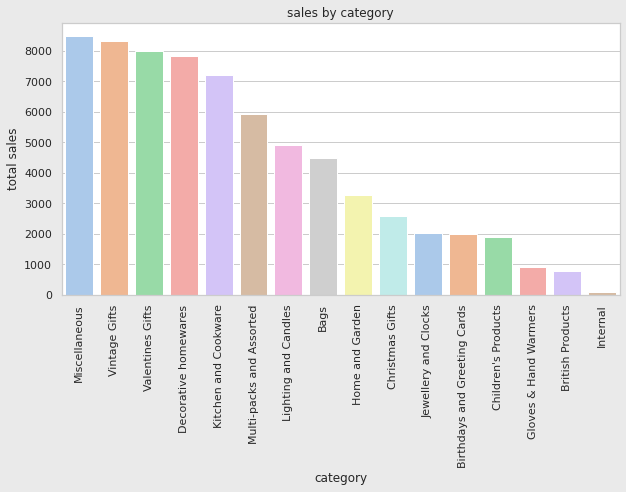

                        category  total sales  total sales revenue
12                 Miscellaneous         8495           156088.843
15                 Vintage Gifts         8324           148848.000
14              Valentines Gifts         7997           105440.670
5           Decorative homewares         7827           146680.420
10          Kitchen and Cookware         7211           129669.770
13      Multi-packs and Assorted         5919            56379.530
11          Lighting and Candles         4911            37033.120
0                           Bags         4496            35606.980
7                Home and Garden         3279            40407.660
4                Christmas Gifts         2598            14811.310
9           Jewellery and Clocks         2034            25639.770
1   Birthdays and Greeting Cards         1983             4828.570
3            Children's Products         1883            13490.370
6          Gloves & Hand Warmers          927             3235

In [56]:
top_categories=new_data.groupby('productcat').agg({'invoiceno':'nunique', 'unitprice':'sum'}).reset_index()
top_categories.columns=['category','total sales', 'total sales revenue']
top_categories=top_categories.sort_values(by='total sales',ascending=False)

fig, ax = plt.subplots(figsize=(10,5), facecolor=facecolor)
sns.barplot(x='category', y='total sales', data=top_categories, palette='pastel')
plt.title('sales by category')
plt.xticks(rotation=90)
plt.show()

print(top_categories)

As we can see in our visualisation, our most popular items are vintage gifts, valentines gifts, decorative homewares, kitchen items, multi-packs and miscellaneous items.

### Which products are most popular in each category?

In [57]:
dec_home=new_data[new_data['productcat']=='Decorative homewares']
dec_home.groupby('description').agg(
    {'invoiceno':'nunique','quantity':'mean','unitprice':'mean'}).reset_index().rename(
    columns={'invoiceno':'orders_nu','quantity':'avg_order_size','unitprice':'avg_price'}).sort_values(by='orders_nu',ascending=False).head(10)

,description,orders_nu,avg_order_size,avg_price
324,Party Bunting,979,10.230536,5.770000
19,Assorted Colour Bird Ornament,795,17.203956,1.726885
405,Spotty Bunting,683,6.367052,5.575549
218,Gardeners Kneeling Pad Keep Calm,600,9.608264,1.960182
5,6 Ribbons Rustic Charm,542,8.498175,2.213449
453,Wooden Picture Frame White Finish,538,5.900000,3.142037
251,Hot Water Bottle Keep Calm,482,6.370143,5.264233
346,Please One Person Metal Sign,435,9.576923,2.382081
135,Doormat Keep Calm And Come In,425,4.380841,8.890023
219,Gin + Tonic Diet Metal Sign,359,18.908587,2.717618


In the decorative category our top selling products were party bunting with 1,638 orders and an average order size of 10.9, followed by Color Bird Ornament and wooden picture frames with an order size of 24.7 and 7.34 respectively. The items with the highest average order size was the Assorted Color Bird Ornament with 24.78.

In [58]:
multi_sets=new_data[new_data['productcat']=='Multi-packs and Assorted']
multi_sets.groupby('description').agg(
    {'invoiceno':'nunique','quantity':'mean','unitprice':'mean'}).reset_index().rename(
    columns={'invoiceno':'orders_nu','quantity':'avg_order_size','unitprice':'avg_price'}).sort_values(by='orders_nu',ascending=False).head(10)

,description,orders_nu,avg_order_size,avg_price
32,Jam Making Set With Jars,672,6.216939,5.096107
31,Jam Making Set Printed,646,12.154560,1.886198
183,Set Of 4 Pantry Jelly Moulds,618,9.968304,1.496989
201,Set Of 6 Spice Tins Pantry Design,498,5.222004,4.740491
66,Pack Of 20 Napkins Pantry Design,408,8.092637,0.997316
86,Round Snack Boxes Set Of4 Woodland,366,8.418033,3.409290
0,Baking Set Spaceboy Design,327,4.563636,5.537424
227,Zinc Folkart Sleigh Bells,300,10.439344,2.332328
200,Set Of 6 Soldier Skittles,296,5.298658,4.554128
224,Wooden School Colouring Set,293,11.099668,1.792525


Assorted packs and sets were purchased mostly kitchen and home related with jelly moulds being the most popular set with 11073 orders and an everage order size of 11.6. Jam making sets, spice tins and snake boxes were some of the other popular items in our product dataset.

In [59]:
love_gifts=new_data[new_data['productcat']=='Valentines Gifts']
love_gifts.groupby('description').agg(
    {'invoiceno':'nunique','quantity':'mean','unitprice':'mean'}).reset_index().rename(
    columns={'invoiceno':'orders_nu','quantity':'avg_order_size','unitprice':'avg_price'}).sort_values(by='orders_nu',ascending=False).head(10)

,description,orders_nu,avg_order_size,avg_price
477,White Hanging Heart T-Light Holder,1126,13.074266,3.134473
239,Natural Slate Heart Chalkboard,733,7.574526,3.564797
171,Heart Of Wicker Small,651,10.004511,1.870075
224,Lunch Bag Pink Polkadot,610,7.871545,1.986407
197,Jumbo Bag Pink Polkadot,587,10.117253,2.584590
246,Pack Of 60 Pink Paisley Cake Cases,528,24.631086,0.744195
170,Heart Of Wicker Large,499,5.623274,3.213866
151,Hanging Heart Jar T-Light Holder,436,13.988636,1.533682
361,Pink Regency Teacup And Saucer,431,6.357143,3.730092
441,Small White Heart Of Wicker,416,6.910588,1.761812


Heart-shaped items, pink gifts, cake cases, and love-related products for Valentine's Day are consistently popular among our customers. Notably, these items exhibit both a high average order size and a relatively low value, mirroring the trend observed with our assorted sets and multi-packs.

In [60]:
dec_home=new_data[new_data['productcat']=='Vintage Gifts']
dec_home.groupby('description').agg(
    {'invoiceno':'nunique','quantity':'mean','unitprice':'mean'}).reset_index().rename(
    columns={'invoiceno':'orders_nu','quantity':'avg_order_size','unitprice':'avg_price'}).sort_values(by='orders_nu',ascending=False).head(10)

,description,orders_nu,avg_order_size,avg_price
95,Jumbo Bag Red Retrospot,1074,17.290055,2.464982
105,Lunch Bag Red Retrospot,819,9.919277,2.081349
140,Pack Of 72 Retrospot Cake Cases,701,19.252427,0.745756
37,Baking Set 9 Piece Retrospot,693,4.544540,5.416897
219,Retrospot Tea Set Ceramic 11 Pc,625,4.904153,5.763163
339,Vintage Snap Cards,588,13.456998,1.005987
100,Jumbo Shopper Vintage Red Paisley,557,8.797853,2.672755
166,Red Retrospot Charlotte Bag,548,15.621622,1.132505
252,Set/5 Red Retrospot Lid Glass Bowls,531,5.466543,3.274015
249,Set/20 Red Retrospot Paper Napkins,492,9.347913,1.078946


Retro and vintage themed items included the retrospot themed colors and vintage paisley designs. Most of these items were purchased in bulk with most average orders being over 10 items.

In [61]:
misc_cat=new_data[new_data['productcat']=='Miscellaneous']
misc_cat.groupby('description').agg(
    {'invoiceno':'nunique','quantity':'mean','unitprice':'mean'}).reset_index().rename(
    columns={'invoiceno':'orders_nu','quantity':'avg_order_size','unitprice':'avg_price'}).sort_values(by='orders_nu',ascending=False).head(10)

,description,orders_nu,avg_order_size,avg_price
823,Red Harmonica In Box,409,38.851220,1.422512
129,Blue Harmonica In Box,352,13.234637,1.414860
1120,Wooden Box Of Dominoes,349,8.811798,1.560927
1127,World War 2 Gliders Asstd Designs,336,105.511905,0.322679
734,Pantry Magnetic Shopping List,308,6.085987,1.805764
166,Box Of 6 Mini 50'S Crackers,286,8.489726,2.658425
882,Scandinavian Reds Ribbons,268,6.702206,1.736765
699,Natural Slate Chalkboard Large,262,3.561069,6.360534
700,Natural Slate Rectangle Chalkboard,260,8.835249,2.028352
1026,Travel Sewing Kit,254,8.315175,1.995642


In the miscellaneous category, our range includes shopping lists, musical items, WW2 gliders, and clothing hangers. These items stand out as some of our most popular products in this category.

In [62]:
cookware_items=new_data[new_data['productcat']=='Kitchen and Cookware']
cookware_items.groupby('description').agg(
    {'invoiceno':'nunique','quantity':'mean','unitprice':'mean'}).reset_index().rename(
    columns={'invoiceno':'orders_nu','quantity':'avg_order_size','unitprice':'avg_price'}).sort_values(by='orders_nu',ascending=False).head(10)

,description,orders_nu,avg_order_size,avg_price
214,Regency Cakestand 3 Tier,1038,4.270992,13.991889
239,Set Of 3 Cake Tins Pantry Design,817,4.285366,5.843463
207,Recipe Box Pantry Yellow Design,638,6.358140,3.640760
222,Roses Regency Teacup And Saucer,555,6.880357,3.652071
126,Green Regency Teacup And Saucer,533,6.300557,3.788386
241,Set Of 3 Regency Cake Tins,482,5.154959,5.865537
113,Gardeners Kneeling Pad Cup Of Tea,478,9.281573,1.938944
8,60 Teatime Fairy Cake Cases,458,15.391026,0.681068
201,Popcorn Holder,442,21.279121,1.019341
73,Chocolate Hot Water Bottle,425,5.846512,5.955953


In our cookware category, cake stands remain the most popular items. Additionally, our teacups and saucers boast an average order size of 8.45, indicating strong customer interest. Sets of cake tins have also emerged as popular choices among our customers.

Based on our observations, we can now formulate our second hypothesis where we determine whether our cookware category is more valuable then the other categories in our store. This is because we have high value items and quantity in the cookware category and we need to understand whether efforts can be focused to ;romote these items further.

<b>First Hypothesis:</b>
- H0: Cookware items have a higher average revenue per invoice then other categories.

- H1: There is no significant difference between the revenue in the categories.


### Checking the number of unique products we sell per day

Above we creating a day/time column by diving the total hours by 8 to split our day up

- Hours 0-7 will all get mapped to 0
- Hours 8-15 will all get mapped to 1
- Hours 16-23 will all get mapped to 2

In [63]:
unique_products_by_day=new_data.groupby('daytime').agg({'description':'nunique'}).reset_index()
unique_products_by_day.columns=['invoiceday','products_nu']
unique_products_by_day.sort_values(by='products_nu',ascending=False)

,invoiceday,products_nu
1,1,3731
2,2,3300
0,0,190


In [64]:
late_buyers = new_data.loc[new_data['daytime'].isin([2,0]), 'total_value']
daytime_buyers = new_data.loc[new_data['daytime']==1, 'total_value']

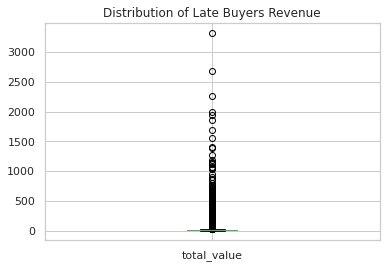

In [65]:
late_buyers.plot(kind='box')
plt.title('Distribution of Late Buyers Revenue')
plt.show()

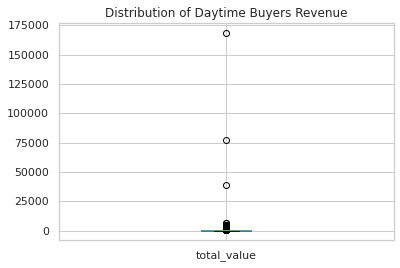

In [66]:
daytime_buyers.plot(kind='box')
plt.title('Distribution of Daytime Buyers Revenue')
plt.show()

Here we can see that the majority of users are purchasing on the website between 8am and 3pm as well as during the evening after 4pm.

Therefore, this opens up our <b>second hypothesis</b>:

- H0: Customers who purchased products late at night/evening were more valuable to the business.

- H1: There was no significant difference between the value of customers at time intervals.

## Additional Exploratory Analysis

As part of the main exploratory analysis, we will be focusing on three important topics. We will look first at a time series analysis and exploring the total revenue per month, the total customers per month and the average invoice value per month. We will also analyse returning customers and new customers by determining the frequancy of purchase, average time between purchases and the lifetime value of customers. 

Understanding the behavior of new and returning customers can help refine marketing strategies, enhance customer engagement initiatives, and foster long-term customer relationships. After completion of our exploration we will declare our hypothesis and perform a test to monitor the results.

1) Time series analysis: 
- Total revenue per month. By product category
- Total revenue by season period
- Total customers and repeat customers per month with the proportion. 

2) Distribution analysis:
- Plot distribution of unit price by category (boxplot).
- Histogram with total value.
- Plot quantity per order (boxplot) 

2) Returning customer analysis: 
- Explore the customers who made repeat purchases over time.
- Calculate metrics such as frequancy of purchase, 
- Average time between purchases 
- The lifetime value of the returning customers

### Time series analysis

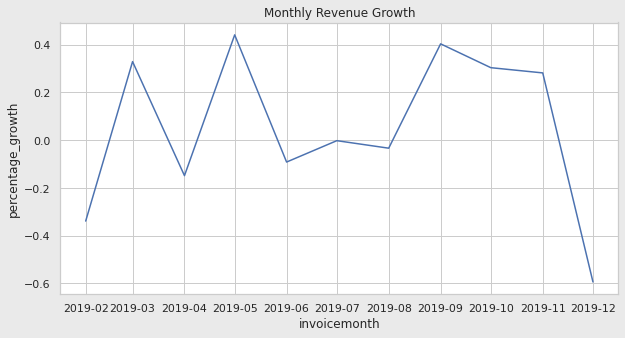

In [67]:
# monthly revenue
revenue_monthly=new_data.groupby('invoicemonth').agg(
    {'total_value':'sum'}).reset_index().rename(
    columns={'total_value':'total_revenue'})
revenue_monthly['percentage_growth']=revenue_monthly['total_revenue'].pct_change()
fig, ax = plt.subplots(figsize=(10,5),facecolor=facecolor)
sns.lineplot(data=revenue_monthly, x='invoicemonth', y='percentage_growth')
ax.set_title("Monthly Revenue Growth")
plt.show()

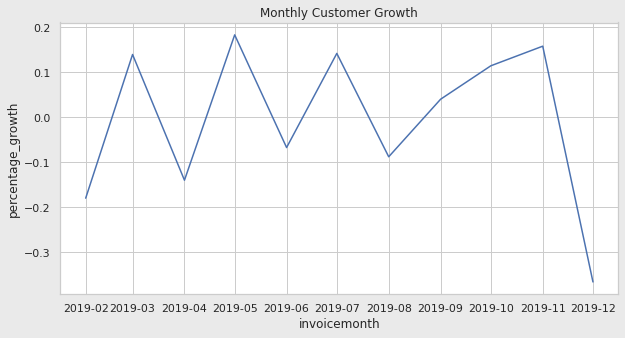

In [68]:
# month total sales
# monthly revenue
customers_monthly=new_data.groupby('invoicemonth').agg(
    {'customerid':'nunique'}).reset_index().rename(
    columns={'customerid':'customer_nu'})
customers_monthly['percentage_growth']=customers_monthly['customer_nu'].pct_change()
fig, ax = plt.subplots(figsize=(10,5),facecolor=facecolor)
sns.lineplot(data=customers_monthly, x='invoicemonth', y='percentage_growth')
ax.set_title("Monthly Customer Growth")
plt.show()

Our time series analysis shows volatilitiy in the growth of customers and in terms of revenue the growth was consistent throughout the year. However, there was a sharp decline by 80% during December. This could also be due to seasonal issues and less orders due to limited postal services over the holiday season.

In [69]:
# Find customers with more than one invoice per month and plot 
customer_orders=new_data.groupby(['invoicemonth','customerid'])['invoiceno'].count().reset_index().rename(columns={'invoiceno':'orders'})
repeat_customers=customer_orders[customer_orders['orders']>1]
repeat_customers.describe()

,customerid,orders
count,15963.000000,15963.000000
mean,15211.916494,17.494143
std,1711.511070,37.324164
min,12349.000000,2.000000
25%,13735.000000,3.000000
50%,15150.000000,7.000000
75%,16669.000000,21.000000
max,18287.000000,2335.000000


In [70]:
customer_orders.describe()

,customerid,orders
count,23305.000000,23305.000000
mean,15212.585068,12.297833
std,1718.927944,31.826157
min,12346.000000,1.000000
25%,13725.000000,1.000000
50%,15164.000000,3.000000
75%,16672.000000,13.000000
max,18287.000000,2335.000000


In [71]:
len(repeat_customers)/len(customer_orders)

0.684960308946578

Upon observation we have 15963 repeat customers, which is 68% of all customers who made an order, there is on average 17 orders and 75% of our customers here have up to 21 orders per month. Therefore, suggesting that we have a good number of loyal customers who regularly return to our website. Below, we will look deeping into returning customers and try to determine our lifetime value.

### Distribution Analysis

Q1:1.25
Q3:4.13
IQR:2.88mean:3.22267679805723
Median:2.08
Standard Deviation:4.630389056372479


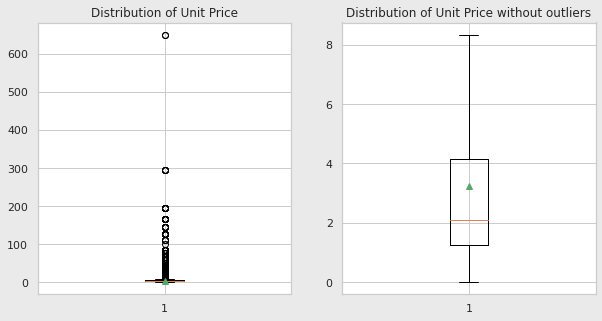

In [72]:
# Box plot unit price
medianup=np.median(new_data['unitprice'])
meanup=np.mean(new_data['unitprice'])
stdup=np.std(new_data['unitprice'])
Q1=new_data['unitprice'].quantile(0.25)
Q3=new_data['unitprice'].quantile(0.75)
IQR=Q3-Q1
print(f"Q1:{Q1}\nQ3:{Q3}\nIQR:{IQR}mean:{meanup}\nMedian:{medianup}\nStandard Deviation:{stdup}")

fig, axes = plt.subplots(1,2, figsize=(10,5),facecolor=facecolor)
axes[0].boxplot(new_data['unitprice'], showmeans=True, showfliers=True,whis=1.5)
axes[0].set_title('Distribution of Unit Price')
axes[1].boxplot(new_data['unitprice'], showmeans=True, showfliers=False,whis=1.5)
axes[1].set_title('Distribution of Unit Price without outliers')
plt.show()

As you can tell our product prices are unevenly distributed and the majority of our products sit within the interquartile range with a variation of 3.23. 

The media unit price is 2.08 and there are a few more overpriced products over the 100 dollar mark. Although, we cleaned our data to remove non-products, manual entries and shipping from our dataframe earlier on to focus solely on actual sales. 

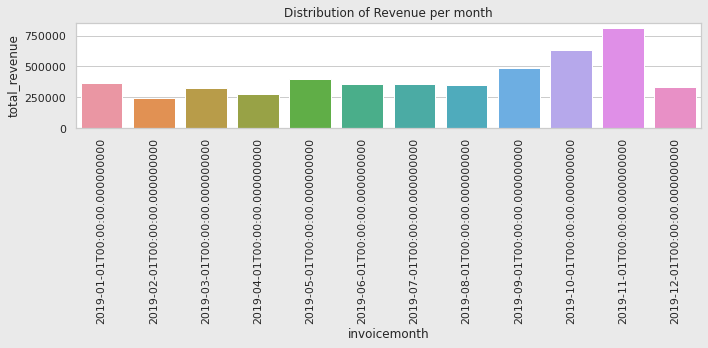

In [73]:
# Histogram total value
fig, ax=plt.subplots(figsize=(10,5),facecolor=facecolor)
sns.barplot(data=revenue_monthly, y='total_revenue',x='invoicemonth')
plt.title('Distribution of Revenue per month')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Despite the highest growth being in May 2019, our best performing month for total revenue was November 2019 when we took in over over 1.4m dollars, a significant increase compared to earlier in the year. 

### Returning customer analysis

Here we will make a cohort analyse of our customers to understand retention patterns and determine the life time value of our customers and which cohort performed best throughout the year. This will help us understand best performing periods and which products impacted the cohorts.

In [74]:
cohort_sizes = (
    new_data.groupby('first_order_month')
    .agg({'customerid': 'nunique'})
    .reset_index()
)
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [75]:
cohorts = new_data.groupby(
    ['first_order_month','invoicemonth']).agg(
    {'total_value': 'sum'}).reset_index().rename(
    columns={'total_value':'total_revenue'})

In [76]:
# Create Cohort Report, we will use a 0.4 margin rate for this calculation as we don't have profit margin details
margin_rate = 0.4

cohort_report=pd.merge(cohort_sizes, cohorts, on='first_order_month')
cohort_report['gross_profit']=cohort_report['total_revenue'] * margin_rate
cohort_report['age']=(cohort_report['invoicemonth'] - cohort_report['first_order_month']) / np.timedelta64(1,'M')
cohort_report.loc[cohort_report['age'] < 0, 'age'] = 0
cohort_report['age']=cohort_report['age'].round().astype('int')
cohort_report['ltv']=cohort_report['gross_profit'] / cohort_report['n_buyers']

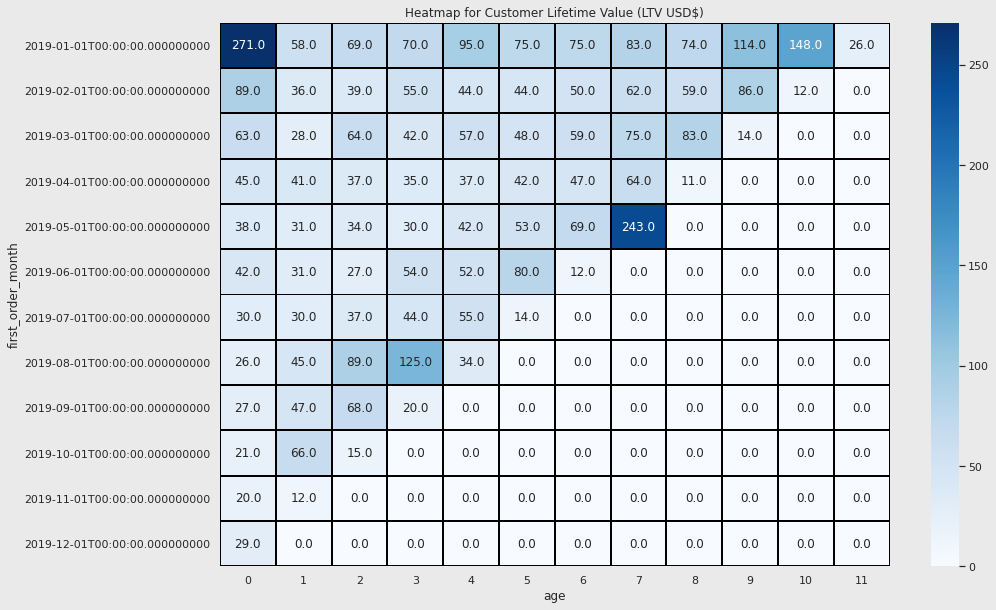

In [77]:
ltv_table= cohort_report.pivot_table(index='first_order_month',columns='age',values='ltv',aggfunc='mean').round()
ltv_table.fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(15,10), facecolor=facecolor)
sns.heatmap(ltv_table, cmap="Blues", annot=True, linecolor='black', linewidths=1, fmt='0')
ax.set_title('Heatmap for Customer Lifetime Value (LTV USD$)')
plt.show()

Above we have a cohort analysis for the lifetime value shows that customers who purchased in each month and how valuable these customers became to use throughout the year. As we started earlier, we are only focusing on January 2019 until the end of 2019.

Our observations tell us that our customers who first purchased in January 2019 were most valuable and maintain an LTV over 50 dollars per month on average. Another valuable cohort are the users who first purchased in May 2015. The 7th month (December) in this cohort was one of the most value with our average LTV being 243 dollars.

### Exploration Conclusions
- Summarise the findings
- List all our hypothesis here for testing

## Statistical Analysis & Hypothesis testing

Hypothesis 1:

- H0: Cookware items have a higher average revenue per invoice then other categories.

- H1: There is no significant difference between the revenue in the categories.

Hypothesis 2:

- H0: Customers who purchased products in the evening or late at night were more valuable to the business.

- H1: There was no significant difference between the value of customers at time intervals.

Hypothesis 3: 

- H0: There were more valuable users with a higher LTV in the first half of the year compared to the second.

- H1: There was no statistical significance between the customers lifetime values during these months.

### Hpothesis 1 - Cookware items Vs. Other Categories

As we are comparing two independent groups where the distributions are different we will use the Mann-Whitney U Test. This is a non-parametric that that is suitable for our test that pits the probability of one category being more valuable than another.

In [78]:
# Split into groups for hypothesis
ordersCookware = new_data[new_data['productcat'] == 'Kitchen and Cookware'].groupby(
    'invoiceno', as_index=False).agg({'total_value': 'mean'})
ordersCookware.columns = ['invoiceid', 'median_rev']
ordersCookware.drop(columns=['invoiceid'],inplace=True)

In [79]:
ordersOtherCat = new_data[new_data['productcat'] != 'Kitchen and Cookware'].groupby(
    'invoiceno', as_index=False).agg({'total_value': 'mean'})
ordersOtherCat.columns = ['invoiceid', 'median_rev']
ordersOtherCat.drop(columns=['invoiceid'], inplace=True)

In [80]:
# Make the test
h0 = "Cookware items have a higher average revenue per invoice then other categories."
h1 = "There is no significant difference between the revenue in the categories."

alpha = 0.05
results = stats.mannwhitneyu(ordersCookware, ordersOtherCat)
print("p-value",results.pvalue)
if (results.pvalue < alpha):
    print(h0)
else:
    print(h1)

p-value [2.89205706e-50]
Cookware items have a higher average revenue per invoice then other categories.


Based on the above the p-value is significantly higher than the alpha, suggesting that there is a strong statistical signifcance between the categories and that there is a strong probability that cookware items are more valuable than the other categories.

### Hypothesis 2 - Time of day test

The distributions are right skewed for both of our samples as we displayed above when we assessed the users by time of day which is our daytime column where we have values of 0,1 and 2 based on the hours.

In [81]:
# Make the test
h0 = "Customers who purchased products in the evening or late at night were more valuable to the business."
h1 = "There was no significant difference between the value of customers at time intervals."

alpha = 0.05
results = stats.ttest_ind(late_buyers, daytime_buyers)
print("p-value",results.pvalue)
if (results.pvalue < alpha):
    print(h0)
else:
    print(h1)

p-value 0.0008659677495464135
Customers who purchased products in the evening or late at night were more valuable to the business.


Based on the statistical test there is a difference between the two groups as the p-value is less than the alpha. This means that there is a high probability that we will support our null hypothesis that customers who purchased late at night our in the evening (after 4pm until 7am) were more valuable in terms of revenue.

In [82]:
cohort_report
Jan_june=cohort_report.loc[cohort_report['first_order_month']<'2019-07-01', 'ltv']
jul_dec=cohort_report.loc[cohort_report['first_order_month']>'2019-07-01', 'ltv']

<AxesSubplot:ylabel='Frequency'>

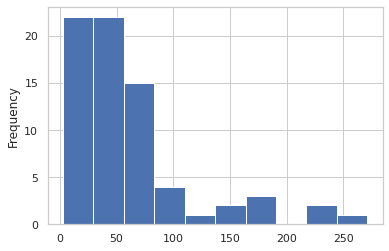

In [83]:
Jan_june.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

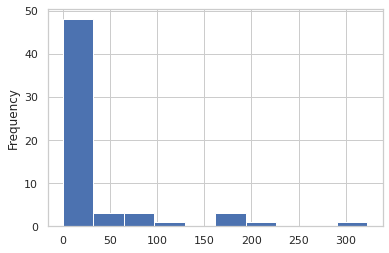

In [84]:
jul_dec.plot(kind='hist')

### Hypothesis 3: Lifetime value test

H0: There were more valuable users with a higher LTV in the first half of the year compared to the second.

H1: There was no statistical significance between the customers lifetime values during these months.

In [85]:
# Make the test
h0 = "There were more valuable users with a higher LTV in the first half of the year compared to the second."
h1 = "There was no statistical significance between the customers lifetime values during these months."

alpha = 0.05
results = stats.ttest_ind(Jan_june, jul_dec)
print("p-value",results.pvalue)
if (results.pvalue < alpha):
    print(h0)
else:
    print(h1)

p-value 0.00655559540158631
There were more valuable users with a higher LTV in the first half of the year compared to the second.


For the third hypothesis we do not reject the null hypothesis as there is a high probability that the users at the start of the year had a higher LTV than those at the end of the year. These results are aligned to the above trend charts that portrayed the sales and customer growth as well as our LTV heatmap which displayed users in our first few cohorts as most valuable.

# Conclusions and Business Recommendations

### Conclusions

In conclusion, we have observed that our homeware and kitchen items tend to be most popular in our online store compared to other categories, and our statistical test has indicated a high probability that kitchen items are more valuable than other categories.

Our sales and customer growth remained stable and positive throughout the year, which is a positive sign. However, in December 2019, we experienced a significant decline. On the other hand, the customer lifetime value was primarily distributed between 10 and 100 dollars, with a few higher-priced customers driving our average LTV over \$250 dollars.

Previously, we conducted a sales growth analysis and main distribution using lemmatisation to categorise our product descriptions. While this method provided a moderate level of insight, it offered only a general idea about each product's main category, leaving us with a large number of miscellaneous items.

### Recommendations for Marketing

- For remarketing campaigns, we should promote multi-pack products in the homeware categories to increase order quantities, particularly where we have low unit prices. This strategy will help boost revenue.

- We should focus our marketing efforts on encouraging repeat purchases when customers buy multi-packs. Sending them reminders every few months to restock can be effective.

- Focus on the holiday seasons
